In [1]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff
using SpecialFunctions, Optim,ExponentialAction
using BenchmarkTools
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature, approximate_meancov, InverseWishartMessage

In [3]:
function generate_data(n,f_gp, σ_x, σ_y)
    obs = []
    for i=1:n
        x_t = σ_x * randn() 
        temp = x_t * exp(f_gp[i])    
        push!(obs, temp)
    end
    return obs
end

generate_data (generic function with 1 method)

In [4]:
Random.seed!(1)

σ_c = 2pi/30 # true frequency
σ_y = 0.001 ## we assume low noise for now

N = 4; #data length
n = 4; #length of the axis of gp 

## GP information
meanf = (x) -> 0.0;
kernel(θ) = with_lengthscale(Matern52Kernel(),θ)
tmin,tmax = 0., 4.0
time_range = collect(range(tmin, tmax; length=n));

θ_gp = 1. #true θ_gp

Cov_mat = kernelmatrix(kernel(θ_gp),time_range,time_range) + 1e-8*I;
gp = MvNormal(meanf.(time_range), Cov_mat)
f_test = rand(gp)

#Observe data 
pos = sort(randperm(n)[1:N]); # position where we observe data
time_train = time_range[pos]
f_train = f_test[pos];
slicedim(dim) = (a) -> map(e -> e[dim], a);

In [5]:
#Generate data 
y_data = generate_data(N,f_train,σ_c,σ_y);

In [6]:
#Exponentiate function 
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily,) = begin 
    return LogNormal(mean(m_x), var(m_x))
end

@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, m_x::UnivariateGaussianDistributionsFamily, ) = begin 
    dist = m_x    
    m_in, var_in = mean_var(m_x)
    l_pdf = (x) -> logpdf(m_y,exp.(x)) 
    pdf = x -> exp(l_pdf(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(131),pdf,dist)

    if isnan(v) || isnan(m)
        log_pdf = x -> l_pdf(x) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [m_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - m_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,2000)
            weights = exp.(l_pdf.(samples)) / sum(exp.(l_pdf.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/2000
                v_ = sum((samples .- m_).^2) /2000 
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - m_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v)
    end
end
@marginalrule MyExponential(:x) (m_y::ContinuousUnivariateLogPdf, m_x::UnivariateGaussianDistributionsFamily, ) = begin 
    b_x = @call_rule MyExponential(:x, Marginalisation) (m_y = m_y, m_x=m_x)
    q_x = ReactiveMP.prod(ProdAnalytical(),b_x,m_x)
    return (x=q_x)
end

In [7]:
#use Gaussian GaussHermiteCubature to approximate 
#Temporarily put here 
# function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
#     N_samples = 500
#     sample_left = rand(left,N_samples)
#     f_samples_evaluated = [exp(logpdf(right,sample_left[i])) for i=1:N_samples]
#     m = sum(sample_left .* f_samples_evaluated) / N_samples
#     v = sum((sample_left .- m).^2 .* f_samples_evaluated) / N_samples
#     @show 1
#     return NormalMeanVariance(m,v)
# end

# function ReactiveMP.prod(::ProdAnalytical, left::ContinuousUnivariateLogPdf, right::UnivariateGaussianDistributionsFamily)
#     N_samples = 500
#     sample_right = rand(right,N_samples)
#     f_samples_evaluated = [exp(logpdf(left,sample_right[i])) for i=1:N_samples]
#     m = sum(sample_right .* f_samples_evaluated) / N_samples
#     v = sum((sample_right .- m).^2 .* f_samples_evaluated) / N_samples
#     return NormalMeanVariance(m,v)
# end

function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
    return left
end

In [8]:
@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    #mean_in and var_in come from m_A
    backward_A = @call_rule typeof(*)(:A, Marginalisation) (m_out = m_out, m_in = m_in, meta=meta)
    mean_in, var_in = mean_var(m_A)
    dist = m_A 
    pdf = x -> exp(backward_A(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(121),pdf,dist)

    if isnan(v) || isnan(m)
        log_pdf = x -> backward_A(x) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [mean_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - mean_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,3000)
            weights = exp.(backward_A.(samples)) / sum(exp.(backward_A.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/3000
                v_ = sum((samples .- m_).^2) /3000
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - mean_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v)
    end
end

@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    backward_A = (x) -> -log(abs(x)) + logpdf(m_in,mean(m_out)/x)
    mean_in, var_in = mean_var(m_A)
    dist = m_A 
    pdf = x -> exp(backward_A(x)-logpdf(dist,x)+1e-7)
    m,v = approximate_meancov(ghcubature(121),pdf,dist)

    if isnan(v) || isnan(m)
        log_pdf = x -> backward_A(x[1]) + logpdf(dist,x[1])  + 1e-7
        res = optimize(x -> -log_pdf(x), [mean_in])
        mproxy = res.minimizer[1]
        dx  = x -> ForwardDiff.derivative(y -> -log_pdf(y),x)
        ddx = x -> ForwardDiff.derivative(dx, x)

        vproxy = cholinv(ddx(mproxy+tiny))
        m_ = mproxy 
        v_ = vproxy + 1e-6

        ksi = m_/v_ - mean_in/var_in
        precision = clamp(1/v_ - 1/var_in, tiny,huge)

        if isnan(ksi) || isnan(precision)
            samples = rand(dist,3000)
            weights = exp.(backward_A.(samples)) / sum(exp.(backward_A.(samples)) )
            if any(isnan.(weights)) 
                m_ = sum(samples)/3000
                v_ = sum((samples .- m_).^2) /3000
            else
                m_ = sum(weights .* samples)
                v_ = sum(weights .* (samples .- m_).^2)    
            end
            ksi = m_/v_ - mean_in/var_in
            precision = clamp(1/v_ - 1/var_in, tiny,huge)
            
            return NormalWeightedMeanPrecision(ksi,precision)
        else
            return  NormalWeightedMeanPrecision(ksi,precision)
        end
    else
        return  NormalMeanVariance(m,v)
    end
end

@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_in::UnivariateGaussianDistributionsFamily, meta::TinyCorrection) = begin 
    backward_A = (x) -> -log(abs(x)) + logpdf(m_in,mean(m_out)/x)
    return ContinuousUnivariateLogPdf(backward_A)
end

@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_in::LogNormal, meta::TinyCorrection) = begin 
    backward_A = (x) -> -log(abs(x)) + logpdf(m_in,mean(m_out)/x)
    return ContinuousUnivariateLogPdf(backward_A)
end

@marginalrule typeof(*)(:A_in) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    b_A = @call_rule typeof(*)(:A, Marginalisation) (m_out = m_out, m_A = m_A, m_in=m_in, meta=meta)
    
    q_A = ReactiveMP.prod(ProdAnalytical(), b_A, m_A)
    return (A = q_A, in = m_in)
end

In [9]:
@model function gpPAD_params(n,P∞::ConstVariable,A::ConstVariable,Q::ConstVariable,H::ConstVariable)
    y = datavar(Float64,n)
    f = randomvar(n)
    z = randomvar(n)
    g = randomvar(n)
    c = randomvar(n)
    # w = randomvar(n)
    
    f_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞)
    f_prev = f_0
    for i=1:n 
        f[i] ~ MvNormalMeanCovariance(A * f_prev, Q)
        z[i] ~ NormalMeanVariance(dot(H , f[i]), 0.02)

        g[i] ~ MyExponential(z[i]) where {pipeline = RequireMessage(x = NormalMeanPrecision(0., 0.01))}
        c[i] ~ NormalMeanPrecision(0.1,1/(σ_c)^2) 
        y[i] ~ (*)(c[i],g[i]) where {meta = TinyCorrection(), pipeline = RequireMessage(A = NormalMeanPrecision(0., 0.5))}
        f_prev = f[i]
    end
end

In [10]:
#### compute matrices for the state-space model corresponding to Matern-52 kernel ######
θ = [0.9, 1.]; # store [l, σ²]
Δt = [time_range[2] - time_range[1]]; # time difference
append!(Δt, time_range[2:end] - time_range[1:end-1]);

λ = sqrt(5)/θ[1];

L = [0., 0., 1.];
H = [1., 0., 0.];
F = [0. 1. 0.; 0. 0. 1.;-λ^3 -3λ^2 -3λ]
Qc = 16/3 * θ[2] * λ^5;

Imat = diageye(3) ; 
vec_P = inv(kron(Imat,F) + kron(F,Imat)) * vec(-L * Qc * L'); 
P∞ = reshape(vec_P,3,3);
# A = [exp(F * i) for i in Δt]; 
# Q = [P∞ - i*P∞*i' for i in A];
A = exp(F*Δt[2])
Q = P∞ - A*P∞*A'

3×3 Matrix{Float64}:
  0.790013  0.26455   -2.23736
  0.26455   1.71645    0.256423
 -2.23736   0.256423  37.8359

In [11]:
nits =2

iresult = inference(
    model = gpPAD_params(length(y_data), P∞,A,Q,H),
    iterations = nits, 
    data  = (y = y_data,),
    returnvars = (f = KeepLast(), z = KeepLast(),g = KeepLast(), c = KeepLast(),),
    options = (limit_stack_depth=500,),
    free_energy = true,
    showprogress = true
)

Inference results:
  Posteriors       | available for (f, c, z, g)
  Free Energy:     | Real[Inf, Inf]


In [19]:
mean.(iresult.posteriors[:z])

4-element Vector{Float64}:
 0.3796212448120778
 0.12953258863111208
 0.05187730284189179
 1.1890447207038994

In [12]:
mgp = mean.(iresult.posteriors[:f]) |> slicedim(1)
vgp = var.(iresult.posteriors[:f]) |> slicedim(1)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp);

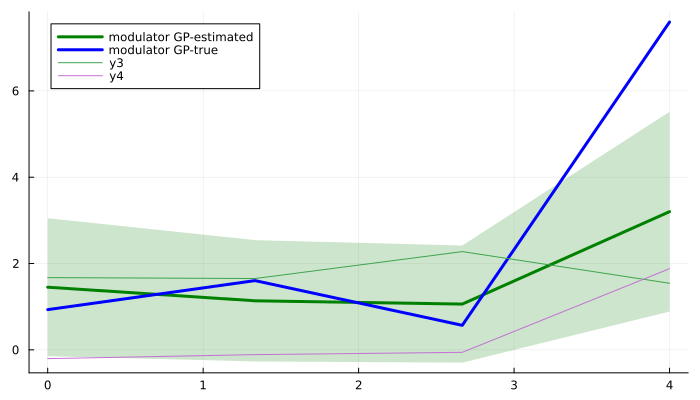

In [13]:
plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green, size = (700, 400))
plot!(time_range,exp.(f_test), label="modulator GP-true",linewidth=3.0,color=:blue)
plot!(time_range,mean.(iresult.posteriors[:g]))
plot!(time_range, y_data)

In [ ]:
function compute_F(logλ)
    F = [0. 1. 0.; 0. 0. 1.;-exp(logλ[])^3 -3exp(logλ[])^2 -3exp(logλ[])]
    return F 
end

function compute_A(logλ)
    F = [0. 1. 0.; 0. 0. 1.;-exp(logλ[])^3 -3exp(logλ[])^2 -3exp(logλ[])]
    Imat = diageye(3)
    A = expv(Δt,F,Imat)
    return A 
end

function compute_P∞(logλ)
    F = [0. 1. 0.; 0. 0. 1.;-exp(logλ[])^3 -3exp(logλ[])^2 -3exp(logλ[])]
    Imat = diageye(3)
    Qc = 16/3 * exp(logλ[])^5
    L = [0., 0., 1.];
    vec_P = inv(kron(Imat,F) + kron(F,Imat)+ 1e-8*diageye(9)) * vec(-L * Qc * L')
    P∞ = reshape(vec_P,3,3)
    return P∞
end

function compute_Q(logλ)
    F = [0. 1. 0.; 0. 0. 1.;-exp(logλ[])^3 -3exp(logλ[])^2 -3exp.(logλ[])]
    Imat = diageye(3)
    A = expv(Δt,F,Imat)
    Qc = 16/3 * exp(logλ[])^5
    L = [0., 0., 1.];
    vec_P = inv(kron(Imat,F) + kron(F,Imat)+ 1e-8*diageye(9)) * vec(-L * Qc * L')
    P∞ = reshape(vec_P,3,3)
    Q = P∞ - A*P∞*A'
    return Q 
end